# 0. Project Overview

The goal of this project is to predict whether a patient is likely to experience a heart faiulure given their medical record.

**Attribute Information:**
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**:: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**:: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**:: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**:: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**:: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**:: output class [1: heart disease, 0: Normal]

**The Plan**
1. Identified the date types, missing values, data distribution, correlation.
2. Split the data into training, validation, test datasets.
3. Initialize a pipeline for transformations.
4. Create a strategy for dealing with outliers and missing values (fill with mean, drop missing values, drop outlier columns).
5. Create new features, perform normalization and other transformations.
6. Initialized the classifiers, select parameters to tune.
7. Performed training with grid search and cross validation.
8. Select the best set of hyper parameters for each classifier.
9. Compare all the classifiers with there best hyper parameters.
10. Select the best model and evaluate it on the test set.
11. Document your findings (feature importance, etc.) 

# 1. Exploring the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

/kaggle/input/heart-failure-prediction/heart.csv
The scikit-learn version is 1.2.2.


In [2]:
data_df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
data_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [3]:
# Check for missing values
data_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in our data.

In [4]:
# Inspect data types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# Inspect unique values
data_df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

* Age, RestingBP, Cholesterol, MaxHR, Oldpeak all have multiple different numerical values
* HeartDisease, FastingBS are binary features with numerical datatypes
* Sex, ExerciseAngina are binary features of object type
* ChestPaintType, ST_Slope, RestingECG are text features with multiple categories

Depending on the model we will use, there might be a need to convert categorical features into numbers  I do not have enough medical knowledge to decide if some of those categories should be ranked. 
For tree based models we can keep the features as text. For models like logistic progression using one hot encoding is necessary.
For now we will create two versions of this dataset - one with all columns encoded, and one with only binary features encoded.

In [6]:
# Given the information from the previous two cells we can split the features into numerical, binary, categorical
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary = ['Sex', 'FastingBS', 'ExerciseAngina']
categorical = ['ChestPainType', 'ST_Slope', 'RestingECG']

target = 'HeartDisease'

In [7]:
data_df['Sex'] = data_df['Sex'].map({'M':1, 'F':0}).astype(int)
data_df['ExerciseAngina'] = data_df['ExerciseAngina'].map({'Y':1, 'N':0}).astype(int)

data_df_encoded = data_df.copy() 
data_df_encoded = pd.concat([data_df_encoded, pd.get_dummies(data_df_encoded, columns=categorical, dtype=int, drop_first=False)], axis=1)
for col in categorical:
    data_df_encoded.drop(col, axis=1, inplace=True)
data_df_encoded.head()
# for col in categorical:
#     data_df_encoded[col] = 

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Age,...,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,0,40,...,0,1,0,0,0,0,1,0,1,0
1,49,0,160,180,0,156,0,1.0,1,49,...,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,37,...,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,48,...,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,54,...,0,0,1,0,0,0,1,0,1,0


In [8]:
# checking if our dataset is balanced
print(data_df[target].value_counts())
data_df[target].value_counts(normalize=True)

HeartDisease
1    508
0    410
Name: count, dtype: int64


HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

We need to check the distribution of our target value to know whether our dataset is balanced. A balance dataset has a similar number of examples for each value of the target variable. In our case the split is 55 to 45%. This information is crucial  for deciding how to split our dataset for training, what metric to use to score our model and what type of model to use.

<Axes: >

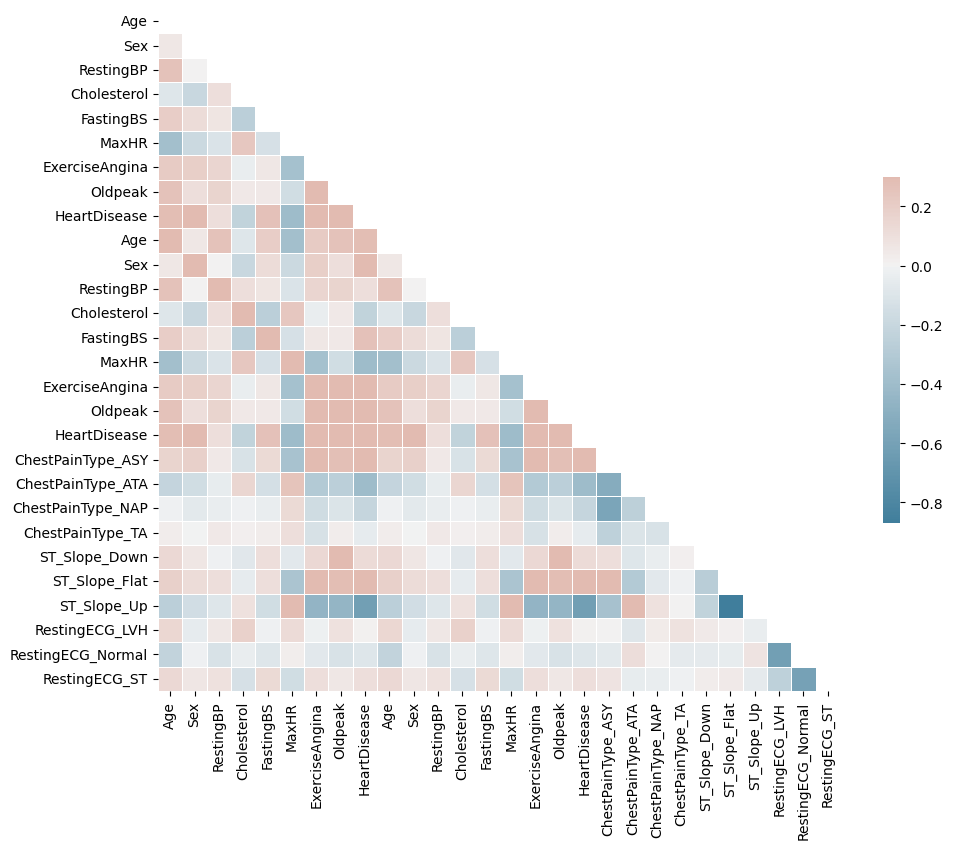

In [9]:
# correlation
# num_bin = numerical.copy()
# num_bin.extend(binary)
# num_bin_targ = num_bin.copy()
# num_bin_targ.append(target)

# Compute the correlation matrix
corr = data_df_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
s = corr.unstack().sort_values()
print(s[0:20])

ST_Slope_Flat      ST_Slope_Up         -0.870951
ST_Slope_Up        ST_Slope_Flat       -0.870951
RestingECG_Normal  RestingECG_LVH      -0.623227
RestingECG_LVH     RestingECG_Normal   -0.623227
HeartDisease       ST_Slope_Up         -0.622164
ST_Slope_Up        HeartDisease        -0.622164
HeartDisease       ST_Slope_Up         -0.622164
ST_Slope_Up        HeartDisease        -0.622164
RestingECG_ST      RestingECG_Normal   -0.602314
RestingECG_Normal  RestingECG_ST       -0.602314
ChestPainType_ASY  ChestPainType_NAP   -0.577670
ChestPainType_NAP  ChestPainType_ASY   -0.577670
ChestPainType_ASY  ChestPainType_ATA   -0.522432
ChestPainType_ATA  ChestPainType_ASY   -0.522432
ST_Slope_Up        ExerciseAngina      -0.455676
ExerciseAngina     ST_Slope_Up         -0.455676
                   ST_Slope_Up         -0.455676
ST_Slope_Up        ExerciseAngina      -0.455676
Oldpeak            ST_Slope_Up         -0.450577
ST_Slope_Up        Oldpeak             -0.450577
dtype: float64


There are no high values for positive correlation between variables. There are negative correlations between various values of the same category but that is to be expected. There seems to be some correlation between our target and ST_Slope.

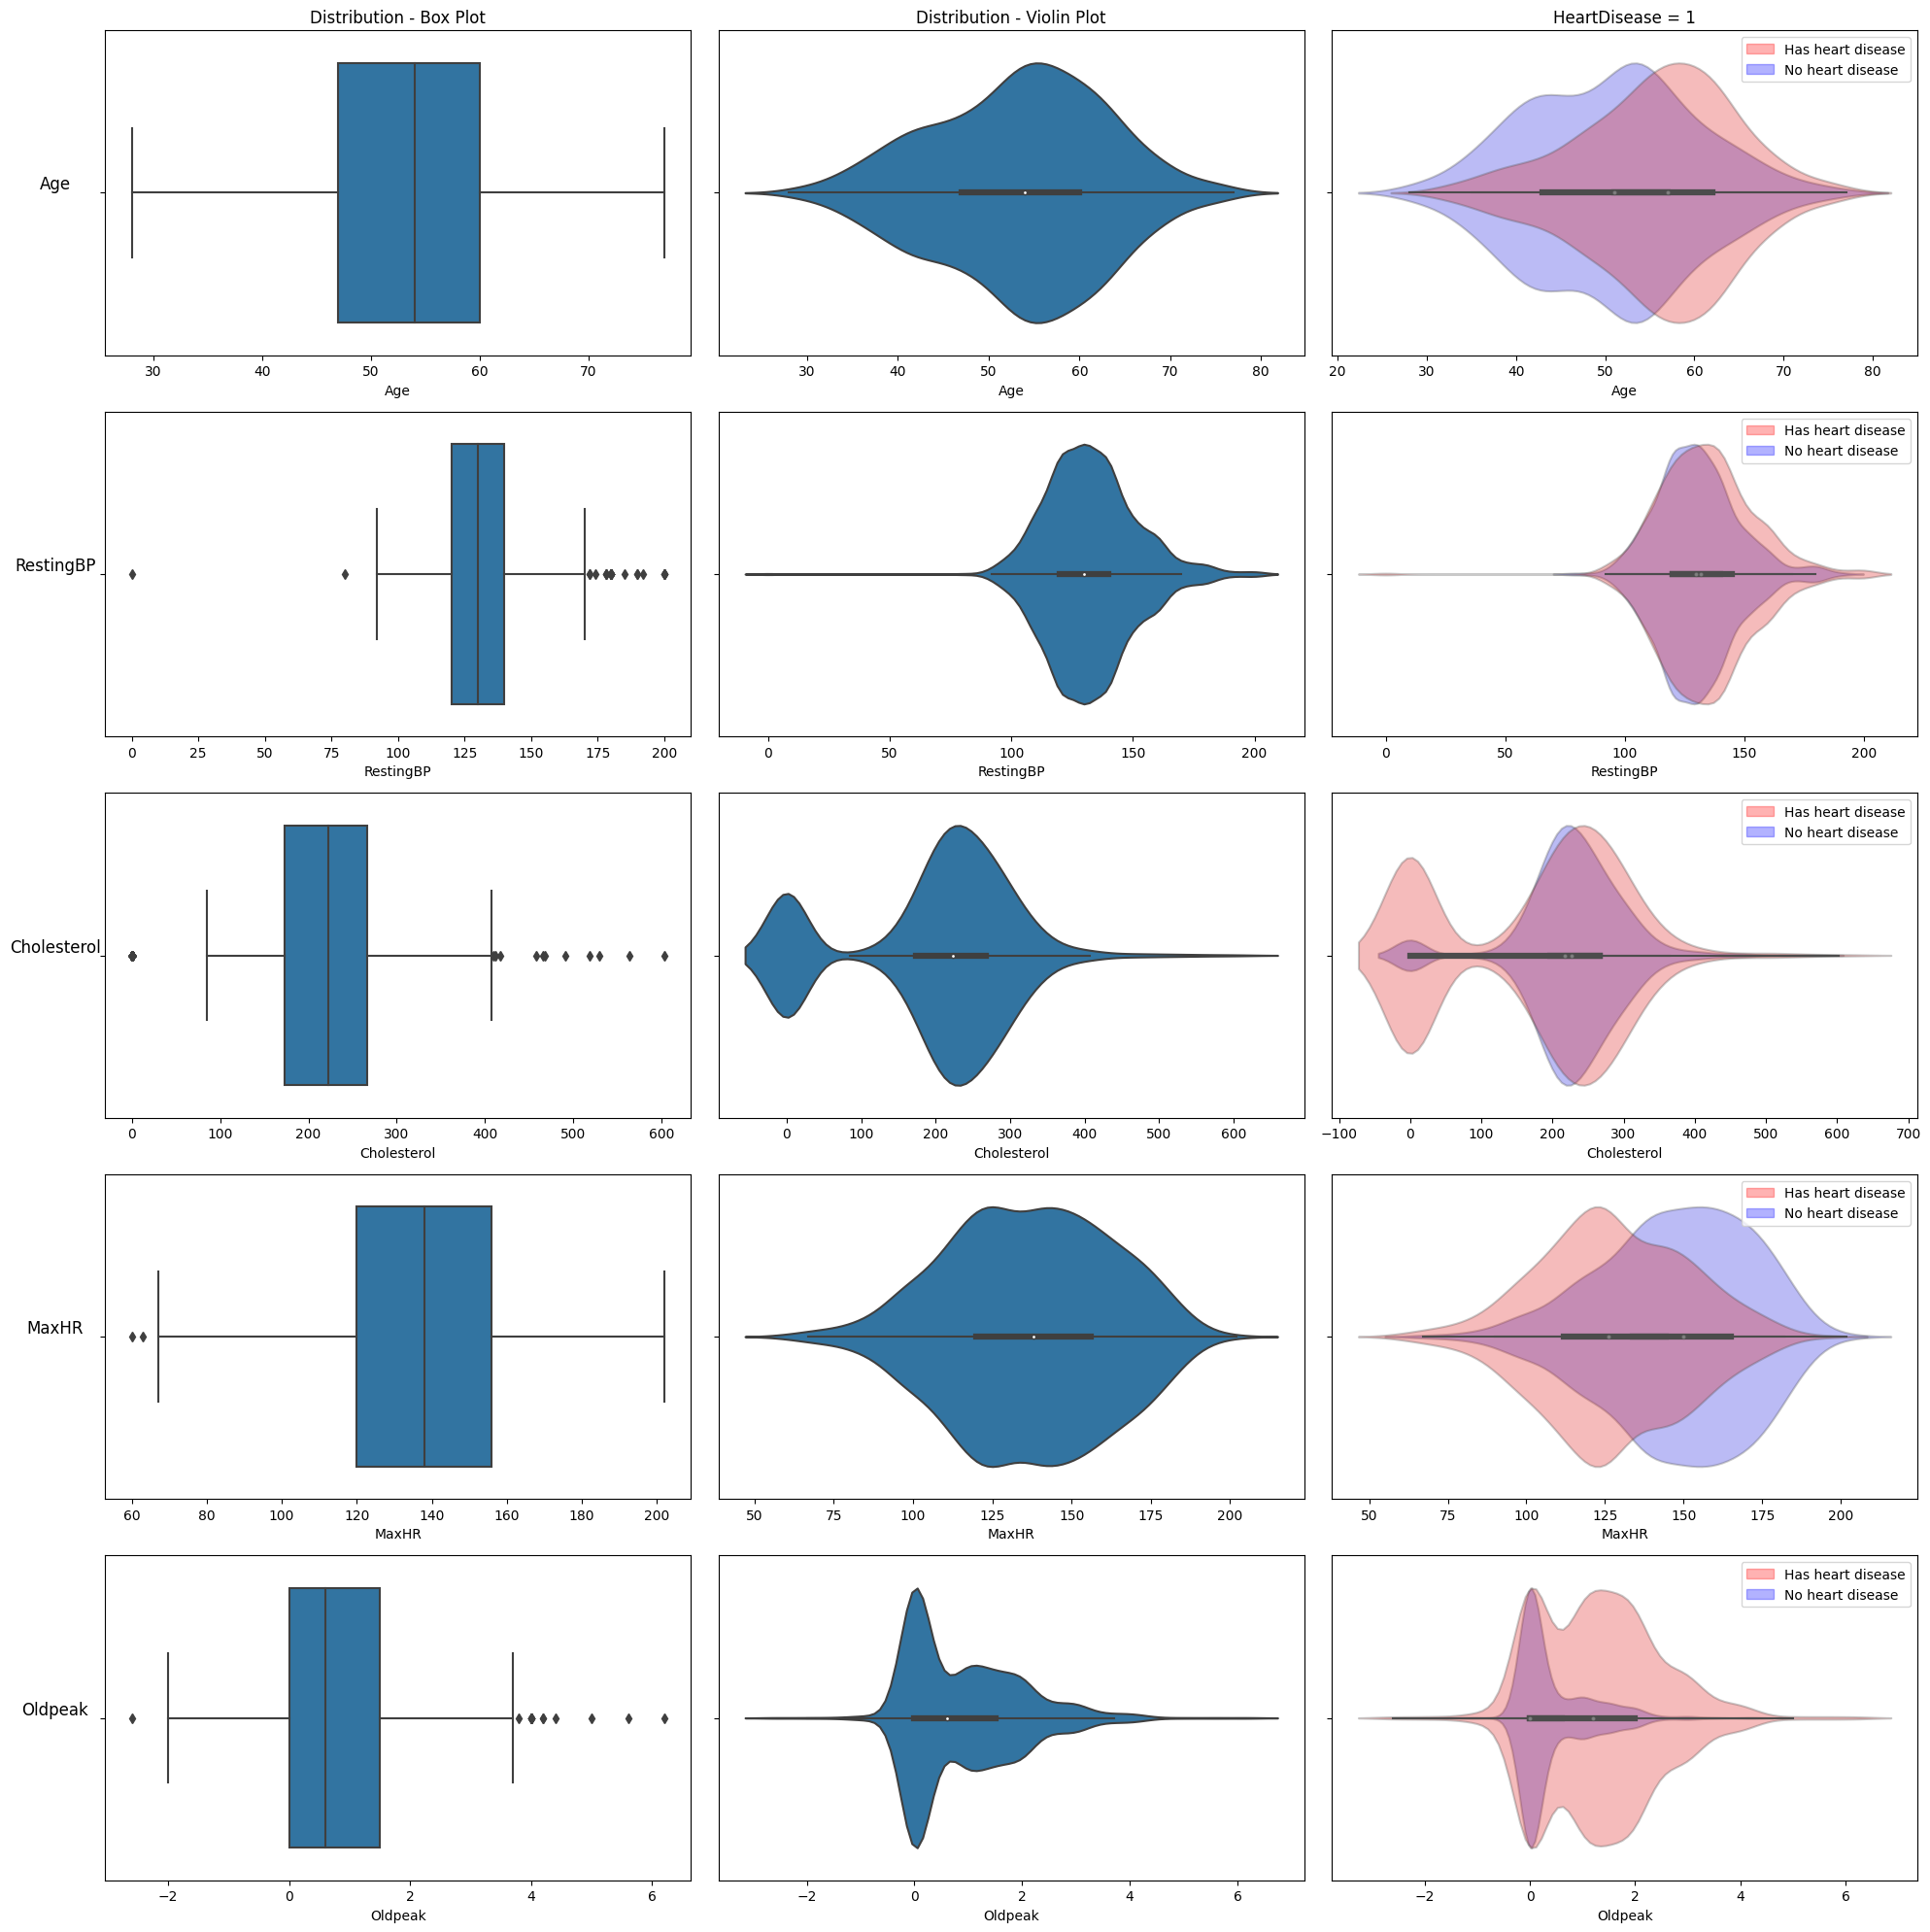

In [11]:
# First we inspect our data distribution for each column.
fig, axs = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(20, 20))

for i, col in enumerate(numerical):
    sns.violinplot(x=data_df[col], ax=axs[i, 1])
    v1 = sns.violinplot(data=data_df.loc[data_df['HeartDisease'] == 0], x=col, ax=axs[i, 2], color='b')
    plt.setp(v1.collections, alpha=.3)
    v2 = sns.violinplot(data=data_df.loc[data_df['HeartDisease'] == 1], x=col, ax=axs[i, 2], color='r')
    plt.setp(v2.collections, alpha=.3)
    red_patch = mpatches.Patch(color='red', label='Has heart disease')
    blue_patch = mpatches.Patch(color='blue', label='No heart disease')
    axs[i, 2].legend(handles=[red_patch, blue_patch])
    for h in axs[i, 2].legend_.legend_handles: h.set_alpha(0.3)
    sns.boxplot(x=data_df[col], ax=axs[i, 0])

column_titles = ['Distribution - Box Plot', 'Distribution - Violin Plot', 'HeartDisease = 1', 'HeartDisease = 0']
for ax, col in zip(axs[0], column_titles):
    ax.set_title(col, size='large')

for ax, row in zip(axs[:,0], numerical):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=30)
fig.tight_layout()
plt.show()

Based on the above we can conclude that:
* Age: People with a heart disease tend to be older.
* MaxHR: People with heart disease measure lower heart rate.
* Oldpeak: People with heart disease measure higher oldpick.

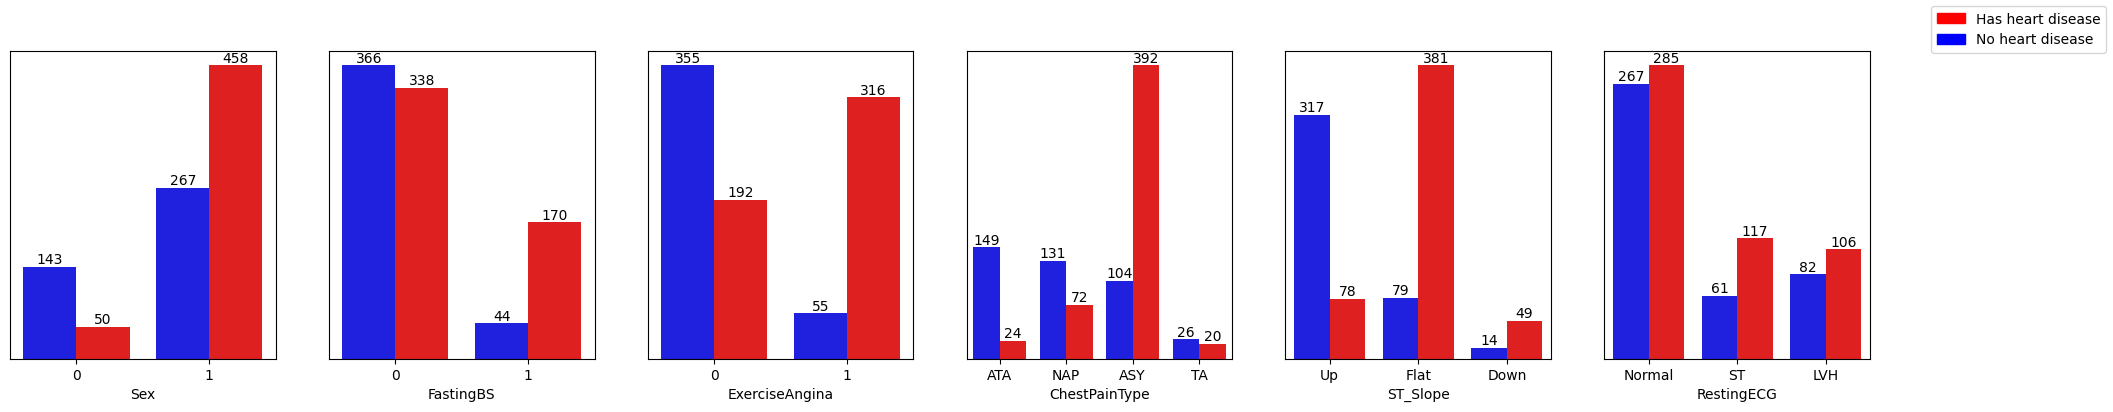

In [12]:
# Now we will analyze categorical featuers
fig, axs = plt.subplots(1, 6, sharex=False, sharey=False, figsize=(24, 4))

for i, col in enumerate(binary+categorical):
    ax = sns.countplot(data=data_df, x=col, ax=axs[i], hue=target, palette = ['blue', 'red'])
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.get_legend().remove()
#     ax.set_xticks([])
plt.figlegend(handles=[red_patch, blue_patch])
plt.show()

Our categorical data suggests that:
* Men are more likely to suffer from a hard disease than women.
* People with fasting blood sugar over 120 are more likely too suffer from heart disease.
* People with exercise angina suffer from a heart disease more often then people without it.
* Chest pain of type ASY often occurs with heart disease.
* Flat ST_Slope often occurs with heart disease.

# 2. Splitting and Transforming Data

First we need to split our data. We will use a 80/10/10 split. The first part will be  used for model training and hyperparameter tuning. We will use cross-validation so as not to split the data any further. The first 10% will be used to select the best model architecture. The last 10% will be used to evaluate our best model. 

In [13]:
from sklearn.model_selection import train_test_split

Y = data_df['HeartDisease']
X = data_df.drop('HeartDisease', axis=1)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, Y, test_size=0.2, random_state=0)
X_validation_df, X_test_df, y_validation_df, y_test_df = train_test_split(X_test_df, y_test_df, test_size=0.5, random_state=0)

print(X_train_df.shape, X_test_df.shape, X_validation_df.shape, y_train_df.shape, y_test_df.shape, y_validation_df.shape)

(734, 11) (92, 11) (92, 11) (734,) (92,) (92,)


In [14]:
# important dependencies
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(numeric_features, categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scalar', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(dtype=int))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)
])

X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)
X_validation = preprocessor.transform(X_validation_df)
y_train = y_train_df.to_numpy()
y_validation = y_validation_df.to_numpy()
y_test = y_test_df.to_numpy()

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak'],
      dtype='object') Index(['ChestPainType', 'RestingECG', 'ST_Slope'], dtype='object')


# 3. Model development

The key factors for our model selection are:
- The problem: **Binary Classification**
- Fairly balanced dataset 55%/45%.
- Small amount of data
-

## 3.1 Importing MLFlow for experiment traciking

In [15]:
!pip install -q mlflow databricks-sdk

In [16]:
# import mlflow
# mlflow.login()

In [17]:
# mlflow.set_tracking_uri("databricks")

In [18]:
# mlflow.set_experiment("/heart-rate-pred")

In [19]:
def train_a_model():
    pass

## 3.3 Decision Tree

In [20]:
n_cores = os.cpu_count()
print(n_cores)

4


In [21]:
from sklearn.metrics import accuracy_score, make_scorer, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
# , "Scores":make_scorer(precision_recall_fscore_support
tree_params = [{'max_depth': list(range(3, 15)), 'max_features': list(range(3,14)), "min_samples_split": list(range(10, 50, 5))}]
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=tree_params,
    scoring=scoring,
    refit="AUC",
    n_jobs=n_cores,
    return_train_score=True,
    verbose=1
)

gs.fit(X_train, y_train)
results = gs.cv_results_

Fitting 5 folds for each of 1056 candidates, totalling 5280 fits


In [22]:
results_df = pd.DataFrame(results).sort_values('mean_test_AUC', ascending=False)
results_df.columns
for col in ['mean_test_Accuracy', 'mean_train_Accuracy', 'mean_test_AUC', 'mean_train_AUC']:
    results_df[col] = np.round(results_df[col], 3)
results_df[['param_max_depth', 'param_max_features', 'param_min_samples_split', 'mean_test_Accuracy', 'mean_train_Accuracy', 'mean_test_AUC', 'mean_train_AUC']]

,param_max_depth,param_max_features,param_min_samples_split,mean_test_Accuracy,mean_train_Accuracy,mean_test_AUC,mean_train_AUC
1004,14,7,30,0.845,0.886,0.914,0.961
757,11,9,35,0.847,0.880,0.913,0.954
828,12,7,30,0.849,0.887,0.913,0.960
916,13,7,30,0.849,0.887,0.913,0.961
398,7,8,40,0.868,0.878,0.912,0.947
...,...,...,...,...,...,...,...
632,10,5,10,0.809,0.922,0.846,0.982
544,9,5,10,0.812,0.918,0.843,0.979
760,11,10,10,0.805,0.931,0.841,0.987
464,8,6,10,0.816,0.923,0.841,0.981


In [23]:
# plt.figure(figsize=(13, 13))
# plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

# plt.xlabel("min_samples_split")
# plt.ylabel("Score")

# ax = plt.gca()
# ax.set_xlim(0, 402)
# ax.set_ylim(0.73, 1)

# # Get the regular numpy array from the MaskedArray
# X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

# for scorer, color in zip(sorted(scoring), ["g", "k"]):
#     for sample, style in (("train", "--"), ("test", "-")):
#         sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
#         sample_score_std = results["std_%s_%s" % (sample, scorer)]
#         ax.fill_between(
#             X_axis,
#             sample_score_mean - sample_score_std,
#             sample_score_mean + sample_score_std,
#             alpha=0.1 if sample == "test" else 0,
#             color=color,
#         )
#         ax.plot(
#             X_axis,
#             sample_score_mean,
#             style,
#             color=color,
#             alpha=1 if sample == "test" else 0.7,
#             label="%s (%s)" % (scorer, sample),
#         )

#     best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
#     best_score = results["mean_test_%s" % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot(
#         [
#             X_axis[best_index],
#         ]
#         * 2,
#         [0, best_score],
#         linestyle="-.",
#         color=color,
#         marker="x",
#         markeredgewidth=3,
#         ms=8,
#     )

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

# plt.legend(loc="best")
# plt.grid(False)
# plt.show()

## 3.4 Random Forest

## 3.5 XGBoost Classifier

In [24]:
# from xgboost import XGBoostClassifier

# bst_model = XGboost

## 3.6 

# 4 Selecting the Best Model

In [25]:
model = gs.best_estimator_
print(model)

DecisionTreeClassifier(max_depth=14, max_features=7, min_samples_split=30,
                       random_state=42)


# 5 Final Results

In [26]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(preprocessor, open('preprocessor.pkl', 'wb'))

In [27]:
# pickled_model = pickle.load(open('/kaggle/working/preprocessor.pkl', 'rb'))
# X_validation2 = pickled_model.transform(X_validation_df)
# print(X_validation==X_validation2)

In [28]:
# f = X_validation_df.iloc[0].to_list()
# # f = (f[0], f[1], f[2], f[3], f[4], f[5], f[6], f[7], f[8], f[9], f[10])
# f = pd.DataFrame(data=[f], columns=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
#        'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
# print(f)
# f = pickled_model.transform(f)
# print(f)

In [29]:
# data = pd.DataFrame(data, columns=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
#        'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'], index=[0])

In [30]:
# X_validation_df.columns